### Helpers

In [1]:
#Packages 
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import json
import string
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from textblob import TextBlob, Word
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import re
from pylab import *

In [15]:
#Moved all functions and importing the module with functions used
import edahelpers as hp
from edahelpers import *

I will use the same functions from EDA notebook - I want to clean the data again before modeling

In [ ]:
# Functions for cleaning

In [2]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'
punctuation += '...'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz','\'em', 'em','haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh','jd', 'je','wow','ii', 'iii', 'it','ima',
                   'imma','jr', 'js','y\'all','y\'']

In [3]:
#Checking my list of stopwords
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:
#Function to have a list of words into one block
def concat_songs(list_lyrics):
    return ' '.join(lyric for lyric in list_lyrics)

In [5]:
def get_tokens(songs, remove_stop_words=True):
    """Splits a string of text into individual words and transform some bad languages"""
    #remove stop words
    stop_words = set(stopwords_list) if remove_stop_words else []
    #tokenize
    words = [x for x in songs.split() if x not in stop_words]
    words = ['Nword' if x in ['nigga', 'niggas','n*gga','n*ggas'] else x for x in words]
    words = ['Fword' if x in ['fuck', 'fucking','fuckin','fuckin\'','fucker','motherfucker','motherfucking','mothafuck', 
                              'mothafucka', 'mothafuckas', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking',
                             'fuckers', 'motherfuck','mother fuckers','motherfuck', 'motherfucka', 'motherfuckas', 
                              'motherfucker','motherfuckers','motherfuckin','motherfucking'] else x for x in words]
    words = ['Bword' if x in ['bitch', 'bitch ', 'ho','hoes','b*tch','bitches', 'bitchin'] else x for x in words]
    return words

In [6]:
#replace in' with ing and digits - converting some rappers names back
def replace_contraction(list_lyrics):
    result = []
    for lyric in list_lyrics:
        lyric = re.sub(r'[0-9]', '# ',lyric)
        lyric = lyric.replace("# pac","2Pac")
        lyric = lyric.replace("# Pac","2Pac")
        lyric = lyric.replace("# chainz","2Chainz")
        lyric = lyric.replace("# Chainz","2Chainz")
        lyric = lyric.replace("# Savage","21Savage")
        lyric = lyric.replace("# Cent","50Cent")
        result.append(lyric.replace("in\'","ing"))
    return result

In [7]:
def lem_words(list_of_tokens,pos): 
    wrd_list = [Word(word).lemmatize(pos=pos) for word in list_of_tokens]
    # join the individual lemmas into a single string
    return wrd_list

In [8]:
#function to create wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=17 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [9]:
#Function to create correlation heatmap - if necessary
def CorrMtx(df, dropDuplicates = True):

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)

## Getting dataframes & Cleaning

In [10]:
#Importing big dataframes
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [11]:
print(df.shape) #(27109, 23)
df.head()

(27109, 23)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",316,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboy, old...",290,1990-00s


In [12]:
df.tail()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
27509,Drake,4PM in Calabasas,Care Package,240217,68,79,0.743,0.660,-4.802,0.418,...,0.549,192.031,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,"[selfpromoters, janky, established, like, yank...","[selfpromoters, janky, establish, like, yankee...",352,2010-20s
27510,House of Pain,The Have Nots,Truth Crushed To Earth Shall Rise Again,264066,32,79,0.686,0.420,-16.039,0.292,...,0.320,95.293,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,"[benevolence, mercy, discipline, benevolence, ...","[benevolence, mercy, discipline, benevolence, ...",211,1990-00s
27511,Future,XanaX Damage,SAVE ME,104013,61,79,0.551,0.609,-8.975,0.143,...,0.324,139.084,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,"[blood, blood, blood, xanax, dreams, xanax, co...","[blood, blood, blood, xanax, dream, xanax, cov...",88,2010-20s
27512,Three 6 Mafia,In da Game,Mystic Stylez,244133,32,79,0.671,0.889,-4.269,0.295,...,0.747,170.528,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,"[dope, game, cocaine, dope, game, dope, dope, ...","[dope, game, cocaine, dope, game, dope, dope, ...",323,1990-00s
27513,M.O.P.,Shake Em Up,Street Certified,197536,10,1,0.371,0.957,-3.475,0.382,...,0.627,87.445,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,"[glitzed, raw, hoodness, sits, car, strange, a...","[glitzed, raw, hoodness, sit, car, strange, an...",225,2010-20s


In [13]:
#Adjust index
df.reset_index(inplace=True,drop=True)

In [14]:
#drop some columns before re-cleaning the data
df = df.drop(columns=['Album','Title','duration_ms','tokens','tokens_lemma'])

In [16]:
print(df.shape) #(27109, 18)
df.tail()

(27109, 18)


,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade
27104,Drake,68,79,0.743,0.660,-4.802,0.418,0.1150,0.000000,0.101,0.549,192.031,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,352,2010-20s
27105,House of Pain,32,79,0.686,0.420,-16.039,0.292,0.1370,0.000000,0.120,0.320,95.293,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,211,1990-00s
27106,Future,61,79,0.551,0.609,-8.975,0.143,0.3680,0.000154,0.192,0.324,139.084,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,88,2010-20s
27107,Three 6 Mafia,32,79,0.671,0.889,-4.269,0.295,0.2680,0.000349,0.216,0.747,170.528,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,323,1990-00s
27108,M.O.P.,10,1,0.371,0.957,-3.475,0.382,0.0736,0.000000,0.743,0.627,87.445,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,225,2010-20s


In [17]:
#Checking if any null values
df.isna().sum()

Artist                 0
popularity             0
num_markets            0
danceability           0
energy                 0
loudness               0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature         0
Year_release        5895
Cleaned_lyrics         0
duration_mins          0
Count_words            0
Decade                 0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27109 entries, 0 to 27108
Data columns (total 18 columns):
Artist              27109 non-null object
popularity          27109 non-null int64
num_markets         27109 non-null object
danceability        27109 non-null float64
energy              27109 non-null float64
loudness            27109 non-null float64
speechiness         27109 non-null float64
acousticness        27109 non-null float64
instrumentalness    27109 non-null float64
liveness            27109 non-null float64
valence             27109 non-null float64
tempo               27109 non-null float64
time_signature      27109 non-null object
Year_release        21214 non-null float64
Cleaned_lyrics      27109 non-null object
duration_mins       27109 non-null float64
Count_words         27109 non-null int64
Decade              27109 non-null object
dtypes: float64(11), int64(2), object(5)
memory usage: 3.7+ MB


In [19]:
#convert number of markets into int
df['num_markets'] = df['num_markets'].astype('int64')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27109 entries, 0 to 27108
Data columns (total 18 columns):
Artist              27109 non-null object
popularity          27109 non-null int64
num_markets         27109 non-null int64
danceability        27109 non-null float64
energy              27109 non-null float64
loudness            27109 non-null float64
speechiness         27109 non-null float64
acousticness        27109 non-null float64
instrumentalness    27109 non-null float64
liveness            27109 non-null float64
valence             27109 non-null float64
tempo               27109 non-null float64
time_signature      27109 non-null object
Year_release        21214 non-null float64
Cleaned_lyrics      27109 non-null object
duration_mins       27109 non-null float64
Count_words         27109 non-null int64
Decade              27109 non-null object
dtypes: float64(11), int64(3), object(4)
memory usage: 3.7+ MB


In [23]:
# get rid of lyrics with less than 25 words - should be taken care already
df.drop(df[df['Cleaned_lyrics'].str.len() < 25].index, inplace=True)

In [25]:
print(df.shape) #(27109, 18)
df.head()

(27109, 18)


,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s


In [26]:
#remove stop words and create token
df['tokens'] = df.Cleaned_lyrics.apply(lambda x: get_tokens(x))

In [27]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, 14, know, Fword, going, know, keep, cand..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ..."


In [28]:
#more words cleaning
df['tokens'] = df.tokens.apply(lambda x: replace_contraction(x))

In [29]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ..."


In [30]:
#Lemmatize for nouns
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'n'))

In [31]:
#Lemmatize for verbs
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'v'))

In [32]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol..."


In [33]:
#updating count words columns
df['Count_words'] = df.lemmatized_lyrics.apply(lambda x: len(x))

In [34]:
df['working_lyrics'] = df.lemmatized_lyrics.apply(lambda x: concat_songs(x))

In [35]:
#Checking if there is null values after cleaning
df.isna().sum()

Artist                  0
popularity              0
num_markets             0
danceability            0
energy                  0
loudness                0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
Year_release         5895
Cleaned_lyrics          0
duration_mins           0
Count_words             0
Decade                  0
tokens                  0
lemmatized_lyrics       0
working_lyrics          0
dtype: int64

In [36]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol...",beat beat beat beat yes go homeboys old school...


## Most frequent words

### All Lyrics

In [ ]:
#Functions to count top words and plots the frequency (from https://github.com/h-parker/commencement-speech-generator/blob/master/nlp-eda.ipynb)

In [37]:
def get_top_n_words(ngram_start, ngram_end, corpus, n=10):
    """
    List the top n words in a vocabulary according to occurrence in corpus.
    """
    vec = CountVectorizer(ngram_range = (ngram_start, ngram_end))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
def plot_top_n_ngrams(corpus, n, ngram_start, ngram_end):
    """
    Given corpus, number of top words you want, the range of 
    ngrams you're interested in (eg, just words: start = 1, end=1;
    words & bigrams: start=1, end=2), this function will graph the
    top words/ngrams in your corpus.
    """
    # get top n words
    top_words = get_top_n_words(ngram_start, ngram_end, corpus, n)
    
    # plot top n words
    fig = plt.figure(figsize=(10,6))
    ax = plt.barh([x[0] for x in top_words], [y[1] for y in top_words], 
            align='center', alpha=0.5,color='r')
    plt.title('Distribution of most frequent words')
    plt.xlabel('# times')
    plt.ylabel('Words')



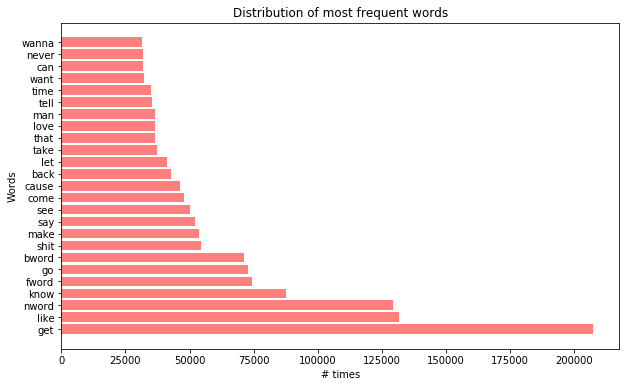

In [39]:
plot_top_n_ngrams(df.working_lyrics, 25, 1, 1)

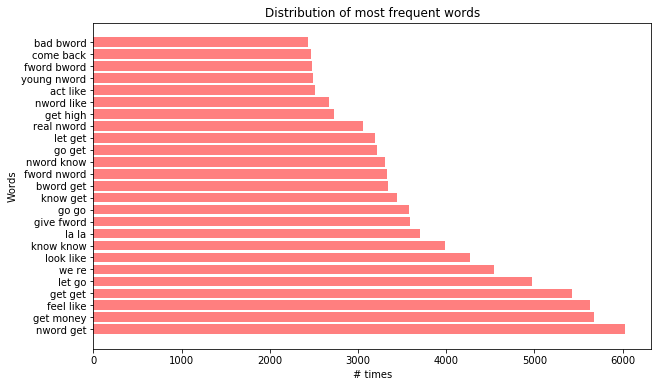

In [40]:
plot_top_n_ngrams(df.working_lyrics, 25, 2, 2)

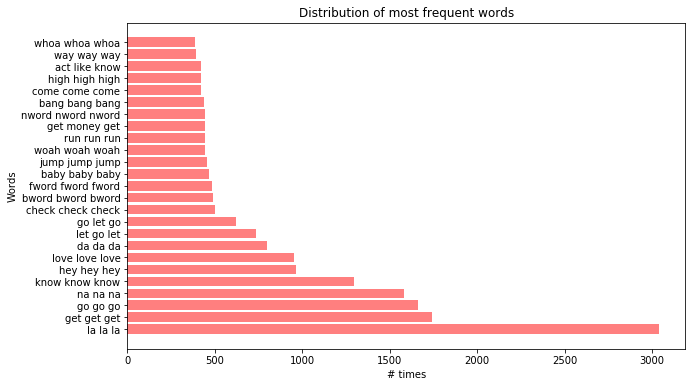

In [41]:
plot_top_n_ngrams(df.working_lyrics, 25, 3, 3)

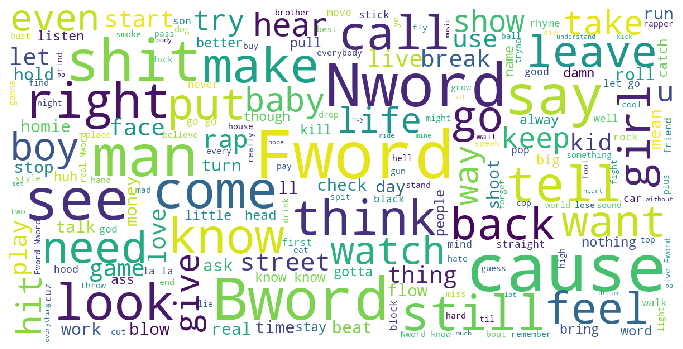

In [42]:
show_wordcloud(list(df.working_lyrics))

## Vectors / TF-IDF (and counter vect)

In [43]:
df.columns

Index(['Artist', 'popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'Year_release',
       'Cleaned_lyrics', 'duration_mins', 'Count_words', 'Decade', 'tokens',
       'lemmatized_lyrics', 'working_lyrics'],
      dtype='object')

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

In [46]:
documents = df.working_lyrics

no_features = 2000

# I will include TF-IDF in the DF for clustering
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=25, max_features=no_features, stop_words=stopwords_list,ngram_range=(1, 3))
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Create as well the Counter vectors just in case
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=25, max_features=no_features, stop_words=stopwords_list,ngram_range=(1, 3))
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

Transform TF-IDF vectors into a DataFrame

In [47]:
#TF-IDF vectorizer into DF
vect_df = pd.DataFrame(tfidf.toarray(), columns=tfidf_feature_names)

In [48]:
#Having a look - checking for length and null values
vect_df.sample(10)

,2pac,ace,across,act,act like,actin,action,add,addict,admit,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
13920,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.090866,0.0,0.0,0.000000,0.0,0.0,0.036781,0.0,0.0
885,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
6602,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.023531,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
26298,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
13298,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
18073,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1853,0.0,0.0,0.0,0.033854,0.0,0.0,0.000000,0.0,0.170125,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
25724,0.0,0.0,0.0,0.000000,0.0,0.0,0.103607,0.0,0.000000,0.0,...,0.000000,0.078119,0.0,0.0,0.079918,0.0,0.0,0.000000,0.0,0.0
2767,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.036166,0.0,0.0,0.000000,0.0,0.0
14471,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.092318,0.042548,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [49]:
vect_df.tail(10)

,2pac,ace,across,act,act like,actin,action,add,addict,admit,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
27099,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27100,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.043042,0.066865,0.0
27101,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.043826,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27102,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.038118,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27103,0.0,0.0,0.0,0.020447,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27104,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27105,0.0,0.0,0.0,0.041794,0.05552,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27106,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27107,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.035378,0.0,0.0,0.027997,0.043492,0.0
27108,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [50]:
vect_df.shape #(27109, 2000)

(27109, 2000)

In [51]:
vect_df.isna().sum()

2pac           0
ace            0
across         0
act            0
act like       0
              ..
yet            0
york           0
young          0
young nword    0
zone           0
Length: 2000, dtype: int64

## Clustering - with TFIDF

### Preparation

In [52]:
print(df.shape)
df.head()

(27109, 21)


,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol...",beat beat beat beat yes go homeboys old school...


In [53]:
df.tail()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
27104,Drake,68,79,0.743,0.660,-4.802,0.418,0.1150,0.000000,0.101,...,192.031,4,2016.0,yeah all you selfpromoters are janky we establ...,4.00,352,2010-20s,"[selfpromoters, janky, established, like, yank...","[selfpromoters, janky, establish, like, yankee...",selfpromoters janky establish like yankees who...
27105,House of Pain,32,79,0.686,0.420,-16.039,0.292,0.1370,0.000000,0.120,...,95.293,4,1996.0,benevolence mercy discipline benevolence mercy...,4.40,211,1990-00s,"[benevolence, mercy, discipline, benevolence, ...","[benevolence, mercy, discipline, benevolence, ...",benevolence mercy discipline benevolence mercy...
27106,Future,61,79,0.551,0.609,-8.975,0.143,0.3680,0.000154,0.192,...,139.084,4,2019.0,blood blood blood xanax dreams xanax covered i...,1.73,88,2010-20s,"[blood, blood, blood, xanax, dreams, xanax, co...","[blood, blood, blood, xanax, dream, xanax, cov...",blood blood blood xanax dream xanax cover bloo...
27107,Three 6 Mafia,32,79,0.671,0.889,-4.269,0.295,0.2680,0.000349,0.216,...,170.528,4,1995.0,dope game cocaine dope game dope dope cocaine ...,4.07,323,1990-00s,"[dope, game, cocaine, dope, game, dope, dope, ...","[dope, game, cocaine, dope, game, dope, dope, ...",dope game cocaine dope game dope dope cocaine ...
27108,M.O.P.,10,1,0.371,0.957,-3.475,0.382,0.0736,0.000000,0.743,...,87.445,1,2014.0,uh from the glitzed to the raw the hoodness th...,3.29,225,2010-20s,"[glitzed, raw, hoodness, sits, car, strange, a...","[glitzed, raw, hoodness, sit, car, strange, an...",glitzed raw hoodness sit car strange angle giv...


In [54]:
df.columns

Index(['Artist', 'popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'Year_release',
       'Cleaned_lyrics', 'duration_mins', 'Count_words', 'Decade', 'tokens',
       'lemmatized_lyrics', 'working_lyrics'],
      dtype='object')

In [55]:
#Keep the columns I will use for clustering
features = df[['popularity','num_markets','danceability','energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo',
       'duration_mins', 'Count_words']]

In [56]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27109 entries, 0 to 27108
Data columns (total 13 columns):
popularity          27109 non-null int64
num_markets         27109 non-null int64
danceability        27109 non-null float64
energy              27109 non-null float64
loudness            27109 non-null float64
speechiness         27109 non-null float64
acousticness        27109 non-null float64
instrumentalness    27109 non-null float64
liveness            27109 non-null float64
valence             27109 non-null float64
tempo               27109 non-null float64
duration_mins       27109 non-null float64
Count_words         27109 non-null int64
dtypes: float64(10), int64(3)
memory usage: 2.9 MB


In [57]:
features.isna().sum()

popularity          0
num_markets         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_mins       0
Count_words         0
dtype: int64

In [58]:
#Concat the features with tf-idf
data_tfidf = pd.concat([features, vect_df], axis=1)

In [59]:
#checking
data_tfidf.tail()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
27104,68,79,0.743,0.660,-4.802,0.418,0.1150,0.000000,0.101,0.549,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27105,32,79,0.686,0.420,-16.039,0.292,0.1370,0.000000,0.120,0.320,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27106,61,79,0.551,0.609,-8.975,0.143,0.3680,0.000154,0.192,0.324,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
27107,32,79,0.671,0.889,-4.269,0.295,0.2680,0.000349,0.216,0.747,...,0.0,0.0,0.0,0.0,0.035378,0.0,0.0,0.027997,0.043492,0.0
27108,10,1,0.371,0.957,-3.475,0.382,0.0736,0.000000,0.743,0.627,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


Go thru the concatenated DF to find if there is any inconsistency

In [60]:
data_tfidf.shape

(27109, 2013)

In [61]:
#Checking for null values
data_tfidf.isna().sum()

popularity      0
num_markets     0
danceability    0
energy          0
loudness        0
               ..
yet             0
york            0
young           0
young nword     0
zone            0
Length: 2013, dtype: int64

In [62]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()

In [63]:
#Scaling data
data_tfidf_norm = pd.DataFrame(norm.fit_transform(data_tfidf),columns=data_tfidf.columns)

In [64]:
data_tfidf_norm.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
0,-0.349869,0.446555,0.342253,-0.839833,-3.052601,-0.637261,-0.807377,-0.151470,-0.937208,1.673276,...,-0.220229,2.521803,-0.146903,-0.126791,-0.213697,-0.208101,-0.168123,-0.318743,-0.148995,-0.16384
1,2.654348,0.446555,0.405464,-0.344820,0.696048,-1.390135,-0.773283,-0.151690,-0.290845,-0.237727,...,-0.220229,-0.268553,-0.146903,-0.126791,-0.213697,-0.208101,-0.168123,-0.318743,-0.148995,-0.16384
2,1.486042,0.446555,0.264996,1.215410,-0.030788,0.922262,-0.120941,-0.151690,-0.676898,1.006538,...,-0.220229,-0.268553,-0.146903,-0.126791,0.804586,-0.208101,8.265936,-0.318743,-0.148995,-0.16384
3,-0.461136,0.404071,0.735564,0.563747,-1.144001,1.076870,0.704151,-0.151690,0.332356,0.001735,...,-0.220229,-0.268553,-0.146903,-0.126791,-0.213697,-0.208101,-0.168123,-0.318743,-0.148995,-0.16384
4,-1.073106,0.361587,0.805797,-1.328580,-2.270007,-0.159993,-0.716149,-0.150494,0.883861,0.222416,...,-0.220229,-0.268553,-0.146903,-0.126791,2.103546,-0.208101,-0.168123,-0.318743,-0.148995,-0.16384


In [65]:
data_tfidf_norm.isna().sum()

popularity      0
num_markets     0
danceability    0
energy          0
loudness        0
               ..
yet             0
york            0
young           0
young nword     0
zone            0
Length: 2013, dtype: int64

In [ ]:
#Let's cluster

### Finding number of k

In [67]:
# Required packages
from sklearn.cluster import KMeans
from sklearn import metrics

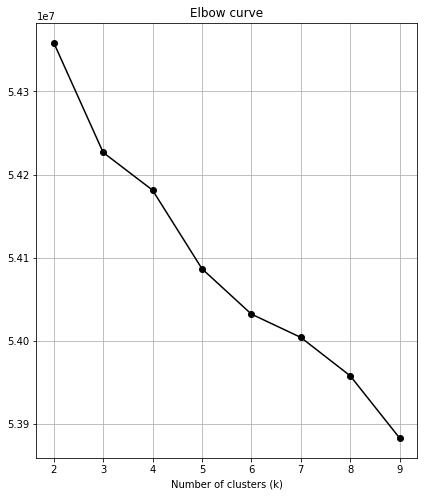

In [69]:
#Elbow
# Specifying the dataset and initializing variables
X = data_tfidf_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 10), distorsions,'-o',color='black')
plt.grid(True)

In [70]:
#Silhouette
# Generate silhouette coefficient for each k
X = data_tfidf_norm
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

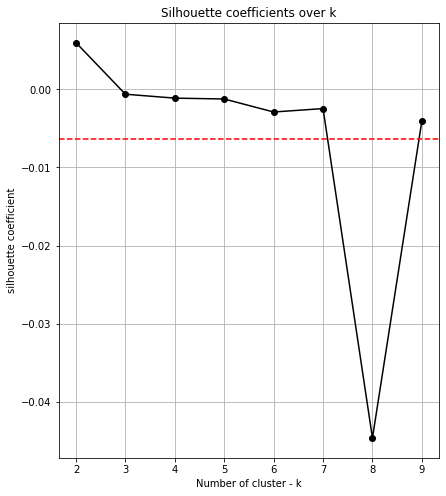

In [71]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

### Clustering and Analysis

In [72]:
model_2 = KMeans(n_clusters=7, random_state=17).fit(data_tfidf_norm)
model_2.cluster_centers_

array([[ 0.07712361,  0.01334369,  0.30521452, ..., -0.01280948,
        -0.00748337, -0.07232177],
       [-0.32593027, -0.07697984, -0.03790624, ...,  0.06069427,
        -0.02795448,  0.03578586],
       [ 0.27467198,  0.11872004,  0.23983348, ...,  0.29564865,
         0.45439169,  0.04437196],
       ...,
       [ 0.17883457, -0.06560192,  0.01465681, ..., -0.14821721,
        -0.10729292, -0.05764178],
       [ 0.02767224,  0.0243098 , -0.32766963, ...,  0.00250499,
        -0.08414527,  0.00095756],
       [-0.49328408,  0.10225207,  0.12336515, ..., -0.1305008 ,
        -0.13902293,  0.10357344]])

In [73]:
#Getting the cluster for each song
cluster_2_labels = model_2.fit_predict(data_tfidf_norm)

In [74]:
cluster_2_labels.shape

(27109,)

In [75]:
#Lyrics join
cluster_2_df = pd.concat([data_tfidf, pd.Series(cluster_2_labels, name='cluster')], axis=1, join='outer')

In [76]:
cluster_2_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,years,yell,yellow,yes,yet,york,young,young nword,zone,cluster
0,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.061263,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6
1,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4
2,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.000000,0.0,0.0,0.033553,0.0,0.199301,0.0,0.0,0.0,3
3,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6
4,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.000000,0.0,0.0,0.076353,0.0,0.000000,0.0,0.0,0.0,6


In [77]:
cluster_2_df.shape

(27109, 2014)

In [78]:
cluster_2_df.cluster.value_counts()

4    7725
5    5608
1    4913
2    3961
0    2379
6    2357
3     166
Name: cluster, dtype: int64

* PCA for visualization

In [81]:
cluster_2_df.isna().sum()

popularity      0
num_markets     0
danceability    0
energy          0
loudness        0
               ..
york            0
young           0
young nword     0
zone            0
cluster         0
Length: 2014, dtype: int64

In [82]:
cluster_features = cluster_2_df.drop(columns=['cluster'])

In [83]:
print(len(cluster_features))
cluster_features.head()

27109


,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
0,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.061263,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.000000,0.0,0.0,0.033553,0.0,0.199301,0.0,0.0,0.0
3,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.000000,0.0,0.0,0.076353,0.0,0.000000,0.0,0.0,0.0


In [84]:
#new packages to import
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=2)
X_new = pca.fit_transform(cluster_features)
x,y = zip(*X_new)
cluster_2_df['x'] = x
cluster_2_df['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [85]:
explained_variance_ratio

array([0.86684342, 0.07116082])

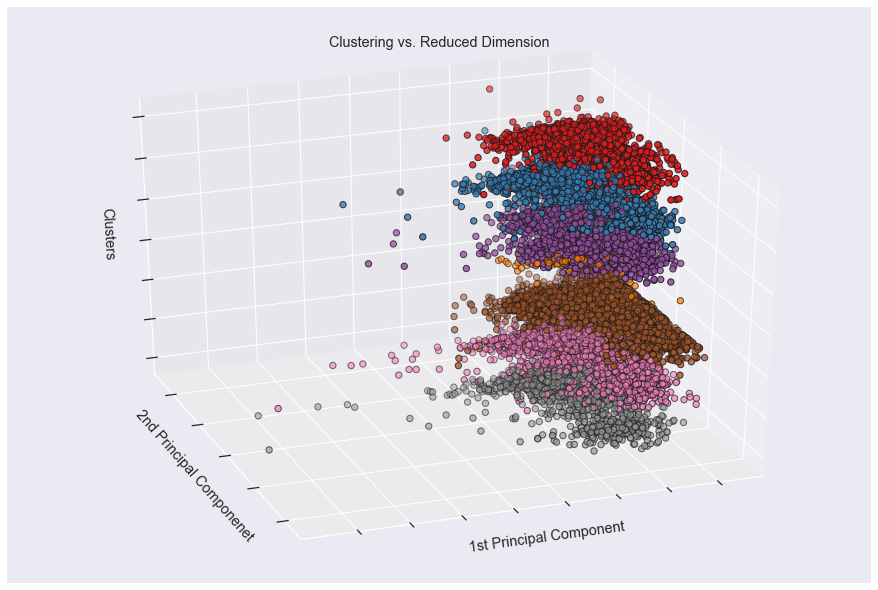

In [116]:
#Visualize components and clusters
fig = plt.figure(1, figsize=(12, 8))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(cluster_2_df['x'], cluster_2_df['y'], cluster_2_df['cluster'], c=cluster_2_df['cluster'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_title('Clustering vs. Reduced Dimension')
ax.set_xlabel("1st Principal Component")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd Principal Componenet")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Clusters")
ax.w_zaxis.set_ticklabels([])

plt.show()

### Labeling and finding songs in clusters

In [87]:
cluster_2_df.head()
list(cluster_2_df.columns)

['popularity',
 'num_markets',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_mins',
 'Count_words',
 '2pac',
 'ace',
 'across',
 'act',
 'act like',
 'actin',
 'action',
 'add',
 'addict',
 'admit',
 'afford',
 'afraid',
 'age',
 'ago',
 'ahead',
 'ahh',
 'aim',
 'air',
 'ak',
 'album',
 'alive',
 'almost',
 'alone',
 'along',
 'already',
 'already know',
 'alright',
 'always',
 'amaze',
 'america',
 'american',
 'angel',
 'another',
 'answer',
 'anybody',
 'anyone',
 'anything',
 'anyway',
 'apart',
 'approach',
 'arm',
 'army',
 'around',
 'around get',
 'around world',
 'art',
 'artist',
 'ash',
 'ask',
 'ass',
 'ass bword',
 'ass like',
 'ass nword',
 'atlanta',
 'attack',
 'attention',
 'attitude',
 'automatic',
 'average',
 'away',
 'aye',
 'ayo',
 'babe',
 'baby',
 'baby baby',
 'baby get',
 'baby girl',
 'baby know',
 'baby let',
 'back',
 'back back',
 'back get',
 'back like',
 'bac

In [90]:
cluster_centers = pd.DataFrame(model_2.cluster_centers_,columns=cluster_features.columns)

In [91]:
cluster_centers

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
0,0.077124,0.013344,0.305215,-0.139452,-0.007962,0.132051,-0.076242,-0.084512,0.001607,0.062101,...,-0.049594,-0.109664,0.029482,-0.014045,-0.085718,-0.082624,-0.091072,-0.012809,-0.007483,-0.072322
1,-0.325930,-0.076980,-0.037906,0.324828,0.215536,0.287307,-0.189014,-0.043212,0.042088,0.214003,...,0.042957,0.053194,0.061061,0.003028,-0.031363,0.010873,0.043532,0.060694,-0.027954,0.035786
2,0.274672,0.118720,0.239833,-0.231229,0.091085,-0.194731,-0.147502,-0.084789,-0.039932,-0.388405,...,-0.051575,-0.144718,-0.063321,0.188496,-0.101701,-0.074310,-0.110118,0.295649,0.454392,0.044372
3,-0.266083,0.034003,-0.339016,0.246386,0.051462,0.470923,-0.089783,-0.098508,0.111488,0.174999,...,0.072924,0.034597,0.008620,0.010963,-0.121961,-0.032217,9.363258,-0.001573,-0.098197,0.098014
4,0.178835,-0.065602,0.014657,-0.151430,-0.090446,-0.251378,0.111637,0.118983,-0.009621,-0.009440,...,-0.095552,-0.159984,-0.061128,-0.044553,0.020540,-0.094962,-0.116413,-0.148217,-0.107293,-0.057642
5,0.027672,0.024310,-0.327670,0.058076,-0.001967,0.013218,0.217308,-0.017915,-0.001487,-0.108068,...,0.085605,0.259975,0.051921,-0.053487,0.015417,0.149026,-0.083828,0.002505,-0.084145,0.000958
6,-0.493284,0.102252,0.123365,0.193035,-0.296815,0.354366,-0.157783,-0.022537,0.004973,0.419710,...,0.151542,0.146360,0.025583,-0.036399,0.227392,0.144540,0.107789,-0.130501,-0.139023,0.103573


In [92]:
cluster_summary_c = cluster_centers[['popularity','num_markets',
                'danceability','energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness','liveness',
       'valence','tempo','duration_mins','Count_words']]

In [93]:
cluster_summary_c.head(10)

,popularity,num_markets,danceability,energy,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words
0,0.077124,0.013344,0.305215,-0.139452,-0.080507,-0.007962,0.132051,-0.076242,-0.084512,0.001607,0.062101,0.023735,-0.043509,0.152916
1,-0.325930,-0.076980,-0.037906,0.324828,-0.040281,0.215536,0.287307,-0.189014,-0.043212,0.042088,0.214003,-0.103340,0.065969,0.248405
2,0.274672,0.118720,0.239833,-0.231229,-0.068918,0.091085,-0.194731,-0.147502,-0.084789,-0.039932,-0.388405,0.323635,-0.144276,0.037552
3,-0.266083,0.034003,-0.339016,0.246386,0.153653,0.051462,0.470923,-0.089783,-0.098508,0.111488,0.174999,-0.161595,-0.310869,-0.064911
4,0.178835,-0.065602,0.014657,-0.151430,-0.023216,-0.090446,-0.251378,0.111637,0.118983,-0.009621,-0.009440,0.052926,-0.174137,-0.328003
5,0.027672,0.024310,-0.327670,0.058076,0.081642,-0.001967,0.013218,0.217308,-0.017915,-0.001487,-0.108068,-0.115454,0.257396,0.029973
6,-0.493284,0.102252,0.123365,0.193035,0.152056,-0.296815,0.354366,-0.157783,-0.022537,0.004973,0.419710,-0.239809,0.129068,0.273042


In [99]:
testing = norm.inverse_transform(model_2.cluster_centers_)

In [101]:
cluster_center_df = pd.DataFrame(testing,columns=cluster_features.columns)

In [102]:
cluster_center_df

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yell,yellow,yes,yet,york,young,young nword,zone
0,31.675074,68.802858,0.729726,0.670775,-7.006407,0.275445,0.142614,0.006006,0.235028,0.543857,...,0.003699,0.003488,0.002666,0.002191,0.004217,0.002493,0.001821,0.010308,0.003432,0.001889
1,24.430287,66.676776,0.680872,0.744870,-6.324999,0.298542,0.120882,0.009699,0.242368,0.576208,...,0.005705,0.007064,0.003143,0.002523,0.006008,0.004350,0.005002,0.012785,0.002935,0.004121
2,35.225953,71.283262,0.720417,0.656128,-6.704429,0.226832,0.128882,0.005981,0.227496,0.447909,...,0.003656,0.002719,0.001263,0.006127,0.003690,0.002658,0.001371,0.020701,0.014632,0.004298
3,25.506024,69.289157,0.638000,0.732352,-6.825235,0.325857,0.140004,0.004755,0.254952,0.567901,...,0.006355,0.006656,0.002350,0.002677,0.003023,0.003494,0.225232,0.010687,0.001232,0.005406
4,33.503301,66.944595,0.688356,0.668864,-7.257886,0.218405,0.178819,0.024200,0.232992,0.528620,...,0.002703,0.002384,0.001296,0.001598,0.007718,0.002247,0.001222,0.005746,0.001011,0.002192
5,30.786198,69.060984,0.639615,0.702299,-6.988130,0.257767,0.199183,0.011961,0.234467,0.507614,...,0.006630,0.011604,0.003005,0.001425,0.007549,0.007094,0.001992,0.010824,0.001573,0.003402
6,21.422147,70.895630,0.703834,0.723837,-7.887071,0.308518,0.126900,0.011547,0.235638,0.620019,...,0.008059,0.009110,0.002607,0.001757,0.014534,0.007005,0.006520,0.006343,0.000242,0.005520


In [104]:
cluster_summary_c_2 = cluster_center_df[['popularity','num_markets',
                'danceability','energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness','liveness',
       'valence','tempo','duration_mins','Count_words']]

In [106]:
cluster_summary_c_2

,popularity,num_markets,danceability,energy,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words
0,31.675074,68.802858,0.729726,0.670775,0.000493,-7.006407,0.275445,0.142614,0.006006,0.235028,0.543857,116.535180,3.741929,303.435477
1,24.430287,66.676776,0.680872,0.744870,0.001105,-6.324999,0.298542,0.120882,0.009699,0.242368,0.576208,112.501075,3.863664,314.028496
2,35.225953,71.283262,0.720417,0.656128,0.000670,-6.704429,0.226832,0.128882,0.005981,0.227496,0.447909,126.055762,3.629881,290.637718
3,25.506024,69.289157,0.638000,0.732352,0.004053,-6.825235,0.325857,0.140004,0.004755,0.254952,0.567901,110.651717,3.444639,279.271084
4,33.503301,66.944595,0.688356,0.668864,0.001364,-7.257886,0.218405,0.178819,0.024200,0.232992,0.528620,117.461879,3.596678,250.085307
5,30.786198,69.060984,0.639615,0.702299,0.002959,-6.988130,0.257767,0.199183,0.011961,0.234467,0.507614,112.116504,4.076521,289.796897
6,21.422147,70.895630,0.703834,0.723837,0.004029,-7.887071,0.308518,0.126900,0.011547,0.235638,0.620019,108.168754,3.933827,316.761561


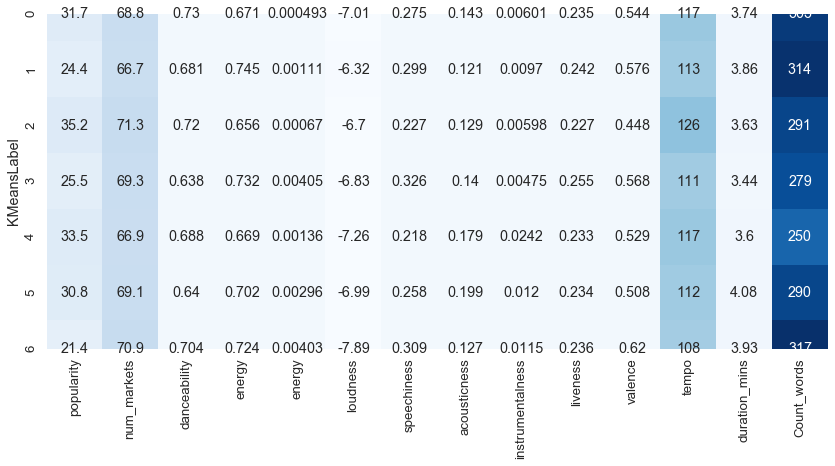

In [112]:
plt.figure(figsize=(14,12))
sns.set(font_scale=1.2)

sns.heatmap(
    data=cluster_summary_c_2,
    annot=True,cmap = "Blues",fmt='.3g',square=True,cbar=False
)
plt.ylabel("KMeansLabel")
plt.show()

In [ ]:
test.shape

In [113]:
cluster_2_df.shape

(27109, 2016)

In [ ]:
cluster_features

In [ ]:
#concat cluster_2_df and artist and title

In [114]:
cluster_2_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,yellow,yes,yet,york,young,young nword,zone,cluster,x,y
0,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6,-52.838607,-54.028471
1,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4,-120.526553,14.722951
2,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.033553,0.0,0.199301,0.0,0.0,0.0,3,174.030001,22.596406
3,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6,29.364704,20.471133
4,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.076353,0.0,0.000000,0.0,0.0,0.0,6,3.110393,8.375337


In [115]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol...",beat beat beat beat yes go homeboys old school...


### Getting songs per cluster

In [141]:
#Getting DF with Title
songs = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [142]:
songs.head()

,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",316,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboy, old...",290,1990-00s


In [143]:
songs.shape

(27109, 23)

In [145]:
songs = songs[['Artist','Title','Album']]

In [146]:
songs.reset_index(inplace=True,drop=True)

In [147]:
songs.tail()

,Artist,Title,Album
27104,Drake,4PM in Calabasas,Care Package
27105,House of Pain,The Have Nots,Truth Crushed To Earth Shall Rise Again
27106,Future,XanaX Damage,SAVE ME
27107,Three 6 Mafia,In da Game,Mystic Stylez
27108,M.O.P.,Shake Em Up,Street Certified


In [148]:
songs_cluster = pd.concat([songs,cluster_2_df],axis=1)

In [149]:
songs_cluster.head()

,Artist,Title,Album,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,...,yellow,yes,yet,york,young,young nword,zone,cluster,x,y
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",24,79,0.735,0.559,-16.289,0.161,0.00172,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6,-52.838607,-54.028471
1,Machine Gun Kelly,Candy,Hotel Diablo,78,79,0.744,0.638,-4.860,0.049,0.00829,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4,-120.526553,14.722951
2,Big Pun,You Ain’t a Killer,Capital Punishment,57,79,0.724,0.887,-7.076,0.393,0.13400,...,0.0,0.033553,0.0,0.199301,0.0,0.0,0.0,3,174.030001,22.596406
3,Das EFX,Buck-Buck,Hold It Down,22,78,0.791,0.783,-10.470,0.416,0.29300,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,6,29.364704,20.471133
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,11,77,0.801,0.481,-13.903,0.232,0.01930,...,0.0,0.076353,0.0,0.000000,0.0,0.0,0.0,6,3.110393,8.375337


In [162]:
songs_cluster_2 = songs_cluster[['Artist','Title','duration_mins','loudness','cluster']]

In [165]:
for i in range(6):
    print('.-'*30)
    print('Cluster'+str(i))
    print('.-'*30)
    display(songs_cluster_2[songs_cluster_2['cluster'] == i].sample(5))

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster0
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
6809,Onyx,Wakedafucup,4.82,-2.083,0
21904,N.O.R.E.,We Don’t,3.80,-7.364,0
1132,N.W.A,1-900-2-COMPTON (Interlude),1.46,-5.885,0
7441,DJ Khaled,F*** The Other Side,3.72,-4.587,0
14453,Chamillionaire,You Got Wrecked,3.49,-3.706,0


.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster1
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
20853,Scarface,Unexpected,4.19,-6.407,1
25754,Lil’ Kim,Thug Luv,4.20,-4.619,1
5988,Xzibit,Paparazzi,3.94,-10.237,1
17910,Royce da 5'9'’,Nickel Nine,4.94,-6.075,1
11014,Bizzy Bone,"Better Run, Better Hide",3.87,-7.649,1


.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster2
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
20686,E-40,I Come from the Game,3.87,-3.385,2
20981,Curren$y,14 Packs,2.49,-9.533,2
26915,Big Boi,In the A,5.33,-5.641,2
8737,Waka Flocka Flame,Rich Gang,4.18,-7.032,2
5387,Meek Mill,The Trillest,4.59,-6.107,2


.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster3
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
2948,N.O.R.E.,Blood Money Pt. 3,3.82,-4.128,3
8521,Papoose,The Beginning,2.92,-6.138,3
26169,Fabolous,The Way (Intro),4.16,-6.186,3
829,Vince Staples,Ramona Park is Yankee Stadium,0.86,-15.368,3
26505,Kool Keith,Ali Baba,4.29,-6.779,3


.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster4
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
3079,Akon,Keep You Much Longer,4.35,-3.146,4
13347,Onyx,Shifftee,3.42,-9.094,4
16193,B.o.B,Out of My Mind,3.72,-5.970,4
22100,Foxy Brown,Tables Will Turn,3.54,-5.617,4
20084,Missy Elliott,Is This Our Last Time,5.43,-7.859,4


.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster5
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
13090,Atmosphere,The Shit That We’ve Been Through,3.58,-3.875,5
9789,Masta Ace,Every Other Day,4.49,-5.926,5
22887,Joyner Lucas,Ross Capicchioni,7.68,-7.798,5
25153,K-Rino,Gone Away,4.67,-11.374,5
7406,Earl Sweatshirt,The Mint,2.75,-4.989,5


In [171]:
print('.-'*30)
print('Cluster'+str(5))
print('.-'*30)
display(songs_cluster_2[songs_cluster_2['cluster'] == 5].sort_values(by='duration_mins').head(15))

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster5
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
12271,Ja Rule,Intro Superstar,0.27,-22.209,5
12913,Atmosphere,Secret,0.32,-26.830,5
749,Chamillionaire,The Final Chapter,0.35,-12.375,5
7920,A$AP Ferg,Uncle,0.38,-5.593,5
22794,Kurupt,Intro,0.64,-17.699,5
7205,Missy Elliott,Religious Blessings - Outro,0.65,-18.310,5
16642,Cormega,Reflection,0.69,-6.677,5
27018,Atmosphere,The Ocean,0.71,-17.234,5
8811,Pitbull,Outro,0.73,-8.116,5
800,Eminem,Hazardous Youth,0.73,-9.502,5


In [172]:
print('.-'*30)
print('Cluster'+str(2))
print('.-'*30)
display(songs_cluster_2[songs_cluster_2['cluster'] == 2].sort_values(by='duration_mins').head(15))

.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Cluster2
.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-


,Artist,Title,duration_mins,loudness,cluster
14575,Three 6 Mafia,Rainbow Colors (interlude),0.14,-1.926,2
17450,Young Buck,Exclusive,0.17,-20.359,2
7316,Project Pat,Hollywood Bay Bay Ambassador Interlude 2,0.33,-20.863,2
20978,DJ Khaled,Movement,0.38,-8.574,2
5986,2 Chainz,Undastatement,0.50,-10.349,2
14106,Jeezy,Done It,0.50,-7.729,2
7761,Future,Name Hold Weight,0.50,-5.043,2
8649,Future,Made Myself a Boss,0.51,-8.526,2
21575,Waka Flocka Flame,Outro (LeBron Flocka James),0.62,-6.059,2
24739,Mick Jenkins,Percy,0.75,-12.448,2


## ARCHIVES >>>>>>>>>>


In [ ]:
#not using anymore

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("---------------------------")
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
#             print (documents[doc_index])  
            print(str(df.Artist[doc_index]))  

In [ ]:
no_topics = 5

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=17, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='batch', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [ ]:
#Number of topic with Artist and titles
no_top_words = 25
no_top_documents = 5

In [ ]:
#Have a look at the topics top words for NMF
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

In [ ]:
#Displaying topic for LDA
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

### Vectorizing

#### TF IDF

In [ ]:
df.head()

In [ ]:
len(df) #27109

after preparing the list of words - Let's get the words into vectors

In [ ]:
#max_df --> ignore words that appear in 95% of the songs 
#ignores words that occur in fewer than 25 songs - use my created stopword list
# I am not interested in more than 1k features
vectorizer = TfidfVectorizer(max_df=0.95, max_features=2000,
                             min_df=25, stop_words=stopwords_list,
                             use_idf=True, ngram_range=(1, 3))

In [ ]:
#using TF-IDF to vectorize 
lyrics_tfidf = vectorizer.fit_transform(df['working_lyrics'])

In [ ]:
#Checking the shape of my TF-IDF vectorizer
print(lyrics_tfidf.shape) #(27109,1000)

In [ ]:
print(vectorizer.get_feature_names())

Transform TF-IDF vectors into a DataFrame

In [ ]:
#TF-IDF vectorizer into DF
vect_df = pd.DataFrame(lyrics_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [ ]:
#Having a look - checking for length and null values
vect_df.sample(10)

In [ ]:
vect_df.shape #(27110, 1000)

In [ ]:
vect_df.isna().sum()

#### Count Vector

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.9, max_features=1000,
                             min_df=25, stop_words=stopwords_list,
                             ngram_range=(1, 3))

In [ ]:
#using counter to vectorize 
tf_vect = count_vectorizer.fit_transform(df['working_lyrics'])

In [ ]:
#Checking the shape of my counter vectorizer
print(tf_vect.shape)

In [ ]:
tf_features = count_vectorizer.get_feature_names()

In [ ]:
print(tf_features)

Create a DF with the features from counter vect

In [ ]:
#Counter vectorizer into DF
tf_df = pd.DataFrame(tf_vect.toarray(), columns=tf_features)

In [ ]:
tf_df.sample(10)

### Transformation SVD and LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD
from time import time
# init svd
print("Performing dimensionality reduction using LSA")
t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=500, random_state=17)
lsa = make_pipeline(svd, Normalizer(copy=False))
# run svd
lyrics_lsa = lsa.fit_transform(lyrics_tfidf)
print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
int(explained_variance * 100)))

print()

In [ ]:
sum(svd.explained_variance_ratio_[0:500])

In [ ]:
lyrics_lsa.shape

In [ ]:
#Trying to understand the components

In [ ]:
# taken from https://github.com/chrisjmccormick/LSA_Classification/blob/master/inspect_LSA.py
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    feat_names = vectorizer.get_feature_names()
    
    # Sort the weights in the first component, and get the indeces
    indices = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indices.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indices[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum))
    grid(True)
    show()

### Latent dirichlet allocation

#### from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

#### v1

In [ ]:
import gensim
from gensim.models import LdaMulticore 
from gensim import corpora, models
from gensim.sklearn_api import TfIdfTransformer

# get all of the words in our corpus & create a bag of words
dictionary = gensim.corpora.Dictionary(df['lemmatized_lyrics'])
bow_corpus = [dictionary.doc2bow(doc) for doc in df['lemmatized_lyrics']]

# get the tf-idf (gensim-style, using their implementation of 
# sklearn's tf-idf model) of our data
model = TfIdfTransformer()
corpus_tfidf = model.fit_transform(bow_corpus)

# use LDA to get 10 topics to split up our descriptions into
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

In [ ]:
lda_categories = [lda_model_tfidf[bow_corpus[i]][0][0] for i in range(0, len(bow_corpus))]

In [ ]:
#Lyrics join(pd.Series(lda_categories))
lda_df = pd.concat([df, pd.Series(lda_categories, name='lda_category')], axis=1, join='outer')

In [ ]:
lda_df.isna().sum()

In [ ]:
lda_df.lda_category.value_counts()

In [ ]:
lda_df.head(25)

#### v2

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Run LDA for 10 topics
no_topics = 10
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf_vect)

In [ ]:
# Function to display the topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])

In [ ]:
# displaying the topic
no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

### Clustering 1 - with LDA

In [ ]:
# Required packages
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets

In [ ]:
lda_df.columns

In [ ]:
features = lda_df[['popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature',
       'duration_mins', 'Count_words','lda_category']]

In [ ]:
features.head()

In [ ]:
#Covert columns in object to float
features['popularity'] = features['popularity'].astype('float64')

In [ ]:
features['num_markets'] = features['num_markets'].astype('float64')

In [ ]:
features.info()

In [ ]:
#Checking for null value due to topic attributes
features.isna().sum()

In [ ]:
features.dropna(inplace=True)

In [ ]:
features.isna().sum()

In [ ]:
len(features)

In [ ]:
#Create dummies variables
ts_dummies = pd.get_dummies(features['time_signature'], prefix='timsign', drop_first=True)
lda_dummies = pd.get_dummies(features['lda_category'], prefix='lda', drop_first=True)

In [ ]:
#Remove the original columns
features = features.drop(['time_signature','lda_category'], axis=1)

In [ ]:
features.head()

In [ ]:
features = pd.concat([features, ts_dummies, lda_dummies], axis=1)
features.head()

In [ ]:
#I forgot to scale my data - let's do it now
from sklearn.preprocessing import Normalizer, MinMaxScaler
norm = Normalizer()

In [ ]:
features_norm = pd.DataFrame(norm.fit_transform(features),columns=features.columns)

In [ ]:
features_norm.head()

#### Elbow Method

In [ ]:
# Specifying the dataset and initializing variables
X = features_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 15), distorsions,'-o',color='black')
plt.grid(True)

#### Silhouette coefficient

In [ ]:
# Generate silhouette coefficient for each k
X = features_norm
silhouette_plot = []
for k in range(2, 15):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

In [ ]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 15), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [ ]:
model_1 = KMeans(n_clusters=4, random_state=10).fit(features_norm)
model_1.cluster_centers_

In [ ]:
cluster_labels = model_1.fit_predict(features_norm)

In [ ]:
len(cluster_labels)

In [ ]:
cluster_labels

In [ ]:
#Lyrics join
cluster_1_df = pd.concat([features, pd.Series(cluster_labels, name='cluster')], axis=1, join='outer')

In [ ]:
cluster_1_df.head()

In [ ]:
cluster_1_df.cluster.value_counts()

In [ ]:
##
cluster_1_df[cluster_1_df['cluster'] == 0]['duration_mins'].plot(kind='hist',color='r',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 1]['duration_mins'].plot(kind='hist',color='b',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 2]['duration_mins'].plot(kind='hist',color='grey',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 3]['duration_mins'].plot(kind='hist',color='black',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 4]['duration_mins'].plot(kind='hist',color='green',bins=50)
plt.title('Duration distribution per cluster')
plt.legend()
plt.show()

In [ ]:
cluster_1_df[cluster_1_df['cluster'] == 0]['Count_words'].plot(kind='hist',color='r',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 1]['Count_words'].plot(kind='hist',color='b',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 2]['Count_words'].plot(kind='hist',color='black',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 3]['Count_words'].plot(kind='hist',color='grey',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 4]['Count_words'].plot(kind='hist',color='green',bins=50)
plt.title('Count words per cluster')
plt.legend()
plt.show()

### Clustering 2 - with TFIDF

#### Preparation

In [ ]:
print(vect_df.shape)
vect_df.head()

In [ ]:
df.columns

In [ ]:
#Keep the columns I will use for clustering
df_short = df[['popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo',
       'duration_mins', 'Count_words']]

In [ ]:
df_short.info()

In [ ]:
df_short.isna().sum()

In [ ]:
#Concat the features with tf-idf
data_tfidf = pd.concat([df_short, vect_df], axis=1)
data_tfidf.tail()

In [ ]:
data_tfidf.shape

In [ ]:
#Checking for null values
data_tfidf.isna().sum()

In [ ]:
#Dropp
data_tfidf.fillna(value=0,inplace=True)

In [ ]:
data_tfidf.shape

In [ ]:
#Checking for null values
data_tfidf.isna().sum()

In [ ]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()

In [ ]:
#Scaling data
data_tfidf_norm = pd.DataFrame(norm.fit_transform(data_tfidf),columns=data_tfidf.columns)

In [ ]:
data_tfidf_norm.head()

#### Let's cluster

In [ ]:
#Elbow
# Specifying the dataset and initializing variables
X = data_tfidf_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 15), distorsions,'-o',color='black')
plt.grid(True)

In [ ]:
#Silhouette
# Generate silhouette coefficient for each k
X = data_tfidf_norm
silhouette_plot = []
for k in range(2, 15):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

In [ ]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 15), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [ ]:
model_2 = KMeans(n_clusters=6, random_state=10).fit(data_tfidf_norm)
model_2.cluster_centers_

In [ ]:
cluster_2_labels = model_2.fit_predict(data_tfidf_norm)

In [ ]:
#Lyrics join
cluster_2_df = pd.concat([data_tfidf, pd.Series(cluster_2_labels, name='cluster')], axis=1, join='outer')


In [ ]:
cluster_2_df.head()

In [ ]:
cluster_2_df.shape

In [ ]:
cluster_2_df.cluster.value_counts()

In [ ]:
##
cluster_2_df[cluster_2_df['cluster'] == 0]['duration_mins'].plot(kind='hist',color='r',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 1]['duration_mins'].plot(kind='hist',color='b',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 2]['duration_mins'].plot(kind='hist',color='black',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 3]['duration_mins'].plot(kind='hist',color='grey',bins=50)
# cluster_2_df[cluster_2_df['cluster'] == 4]['duration_mins'].plot(kind='hist',color='green',bins=50)
# cluster_2_df[cluster_2_df['cluster'] == 5]['duration_mins'].plot(kind='hist',color='steelblue',bins=50)
plt.title('Duration distribution per cluster')
plt.legend()
plt.show()

In [ ]:
#PCA for visualization

In [ ]:
cluster_2_df.dropna(inplace=True)

In [ ]:
test = cluster_2_df.drop(columns=['cluster'])

In [ ]:
len(test)

In [ ]:
test.head()

In [ ]:
len(cluster_2_df)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(test)
x,y = zip(*X_new)
cluster_2_df['x'] = x
cluster_2_df['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [ ]:
explained_variance_ratio

In [ ]:
sns.set(font_scale=1.5)
sns.lmplot(data=cluster_2_df, x='x', y='y', hue='cluster', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.legend(loc='lower right')
# plt.ylim(-0.7,1.8)
# plt.xlim(-0.7,1.8)
# plt.savefig('pca_scatter_genres.png')
plt.title("Clustering - Reduced Dimension")
plt.show()

In [ ]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#Visualize top 3 components
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(cluster_2_df['x'], cluster_2_df['y'], cluster_2_df['cluster'], c=cluster_2_df['cluster'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_title('Clustering vs. Reduced Dimension')
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Cluster")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [ ]:
cluster_2_df.head()

In [ ]:
list(cluster_2_df.columns)

In [ ]:
cluster_centers = pd.DataFrame(model_2.cluster_centers_,columns=test.columns)

In [ ]:
cluster_centers

In [ ]:
cluster_summary_c = cluster_centers[['popularity','num_markets',
                'danceability','energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness','liveness',
       'valence','tempo','duration_mins','Count_words']]

In [ ]:
cluster_summary_c.head(10)

In [ ]:
plt.figure(figsize=(14,12))
sns.set(font_scale=1.2)

sns.heatmap(
    data=cluster_summary_c,
    annot=True,cmap = "Blues",fmt='.1g',square=False
)
plt.ylabel("KMeansLabel")
plt.show()

In [ ]:
test.shape

In [ ]:
cluster_2_df.shape

In [ ]:
#evaluation

In [ ]:
>>> kmeans_model = KMeans(n_clusters=4, random_state=17).fit(data_tfidf_norm)
>>> labels = kmeans_model.labels_
>>> metrics.silhouette_score(X, labels, metric='euclidean')

In [ ]:
# k=4 --- sil = 

In [ ]:
#Calinski-Harabasz Index
>>> import numpy as np
>>> from sklearn.cluster import KMeans
>>> kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
>>> labels = kmeans_model.labels_
>>> metrics.calinski_harabasz_score(X, labels)  
561.62...

In [ ]:
>>> from sklearn.cluster import AgglomerativeClustering
>>> import numpy as np
>>> X = data_tfidf_norm
>>> clustering = AgglomerativeClustering().fit(X)
>>> clustering 
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6,
                        pooling_func='deprecated')


In [ ]:
>>> clustering.labels_

In [ ]:
## Clusters artist

In [ ]:

#open data frame
with open('../Data-Cleaning-EDA/cleaned_year_data.pkl', 'wb') as file:
    pickle.dump(year_df, file)